In [ ]:
#CHECK FOR GPU PRESENCE



In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:

import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### To Do
- import the load the data using tensorflow dataset
-preprocessed the data


In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(Xtrain,ytrain),(_,_)=mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
Xtrain.shape

(60000, 28, 28)

In [5]:
def display_sample(num):
    #Print this sample's label
    label = ytrain[num]

    #Reshape the 784 values to a 28x28 image
    image = Xtrain[num].reshape([28,28])
    plt.title(f'Sample: {num}  Label: {label}')
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

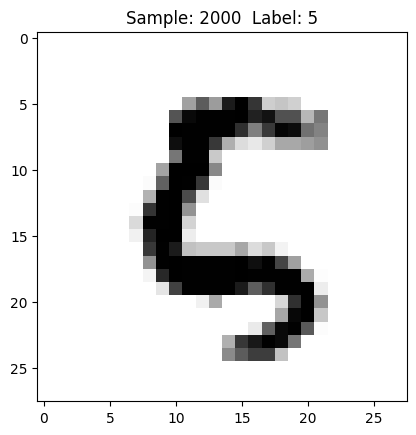

In [6]:
display_sample(2000)

### Nomarlize the data
Convert the shape to float to allow neural network train the model
i.e xtrain.shape[0] is the length of the (Mnist dataset)
x_train=(Xtrain-127.5)/127.5

Note:
The pixex value are originally stored as integer (0-255), GANs work better in the range [-1, 1] instead of [0, 255]



In [7]:
Xtrain=Xtrain.reshape(Xtrain.shape[0],28,28,1).astype('float32')
Xtrain=(Xtrain-127.5)/127.5

In [8]:
Xtrain.shape

(60000, 28, 28, 1)

In [10]:
Buffer_size=60000
Batch_size=256

In [11]:
#Xtrain

In [33]:
#Create the training dataset from tensorflow
train_data=tf.data.Dataset.from_tensor_slices(Xtrain).shuffle(Buffer_size).batch(Batch_size)

In [34]:

LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

In [35]:
#build generator
def build_generator():
  model=keras.Sequential([
    layers.Dense(7*7*256,input_shape=(LATENT_DIM,),use_bias=False, kernel_initializer=WEIGHT_UNIT),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Reshape((7,7,256)),

    layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128,(5,5),strides=(2,2),padding='same',use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1,(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
  ])
  return model
generator=build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
#build descriminator
def build_discriminator():
    model=keras.Sequential([

    layers.Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
        layers.Flatten(),

    layers.Dense(1, activation='sigmoid')
      ])
    return model
discriminator=build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
cross_entropy=keras.losses.BinaryCrossentropy()

In [38]:
#create discriminator loss
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [39]:
#create generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [40]:
generator_optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)

In [41]:
#build subclass model
class GAN(keras.Model):
  def __init__(self,discriminator,generator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.discriminator=discriminator
    self.generator=generator
  def compile(self,discriminator_optimizer,generator_optimizer,d_loss,g_loss):
    super(GAN, self).compile()
    self.discriminator_optimizer=discriminator_optimizer
    self.generator_optimizer=generator_optimizer
    self.d_loss=d_loss
    self.g_loss=g_loss
  def train_step(self, real_image):
    batch_size=tf.shape(real_image)[0]

    #Train descriminator
    noise=tf.random.normal([batch_size,LATENT_DIM])
    with tf.GradientTape() as d_tape:
      generated_image=self.generator(noise)
      real_output=self.discriminator(real_image)
      fake_output=self.discriminator(generated_image)
      d_loss=self.d_loss(real_output,fake_output)

    d_gradient=d_tape.gradient(d_loss,self.discriminator.trainable_variables)
    self.discriminator_optimizer.apply_gradients(zip(d_gradient,self.discriminator.trainable_variables))

     # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}



In [42]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

In [44]:
Epoch=100

In [45]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)


Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - d_loss: 1.0653 - g_loss: 0.9943

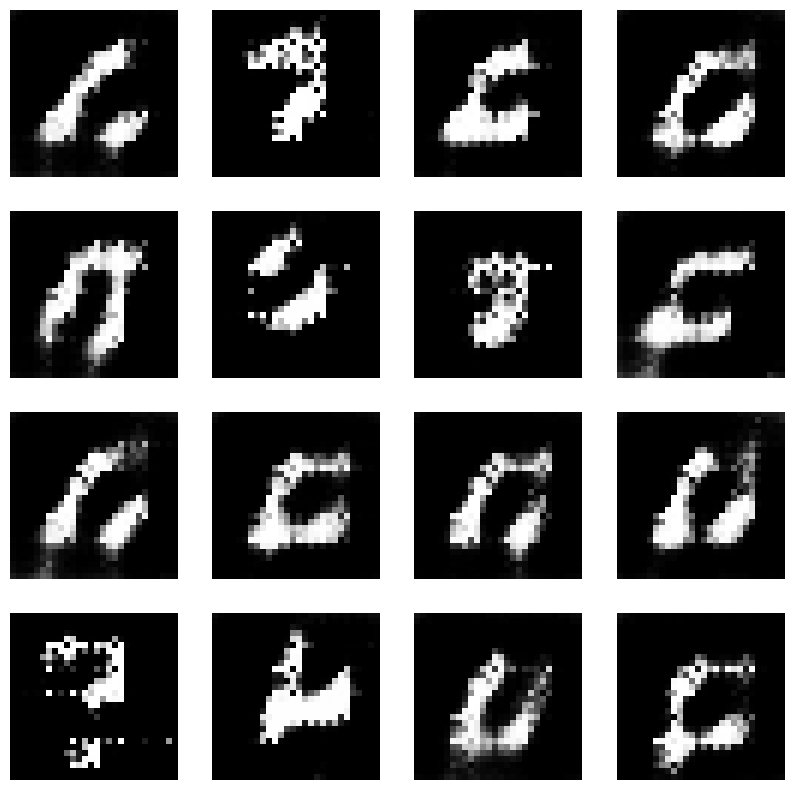

235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - d_loss: 1.0656 - g_loss: 0.9938
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2078 - g_loss: 0.9795
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2189 - g_loss: 0.9436
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.2349 - g_loss: 0.9110
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - d_loss: 1.2930 - g_loss: 0.8420
Epoch 6/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.2936 - g_loss: 0.7906

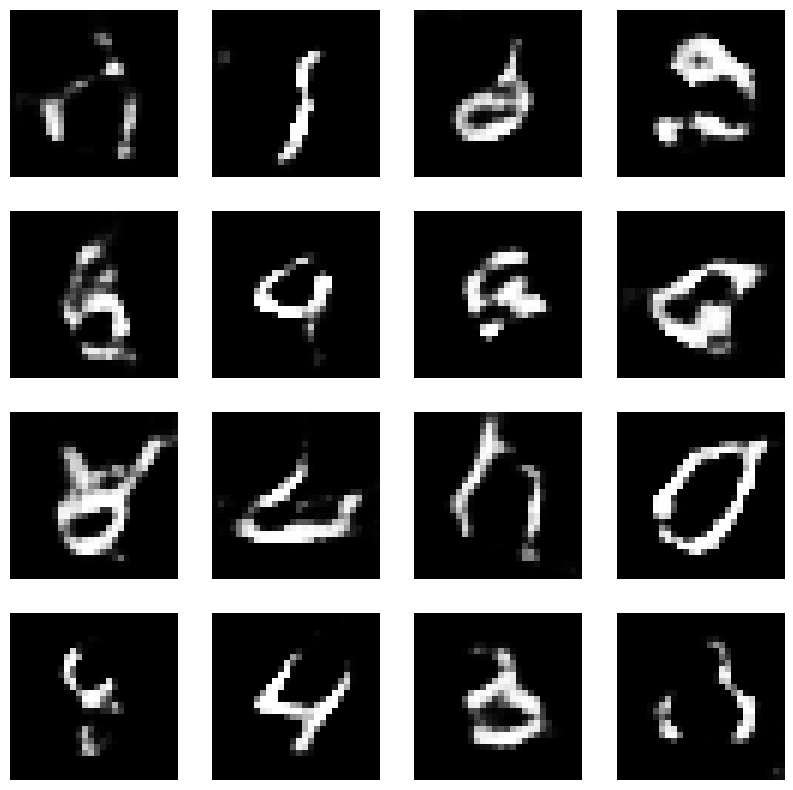

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2933 - g_loss: 0.7906
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3122 - g_loss: 0.8368
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.2999 - g_loss: 0.7926
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2959 - g_loss: 0.8410
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.2856 - g_loss: 0.8439
Epoch 11/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.2673 - g_loss: 0.8067

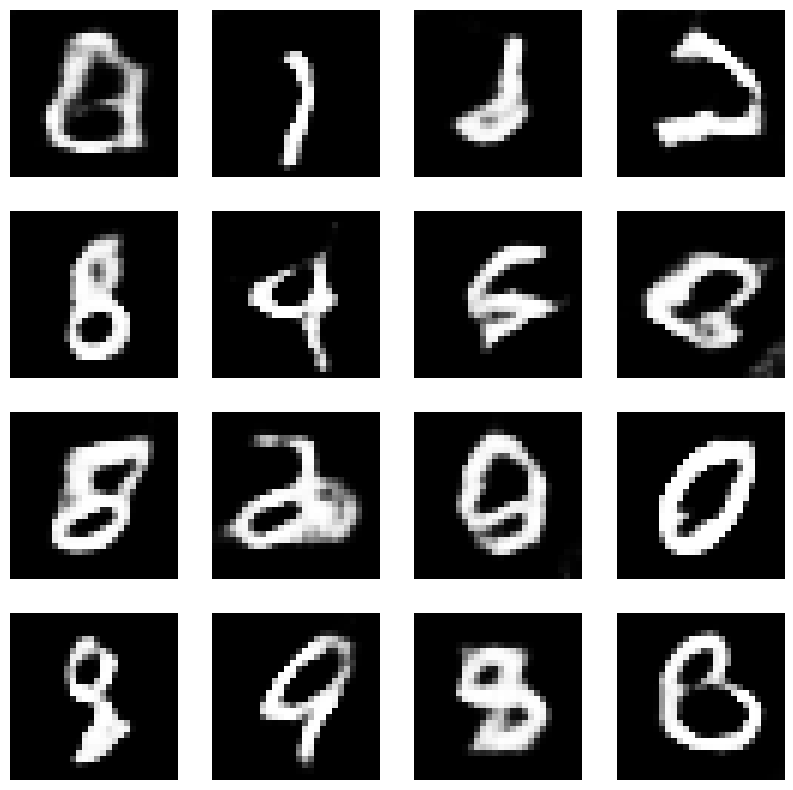

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2671 - g_loss: 0.8073
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2777 - g_loss: 0.8878
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2525 - g_loss: 0.8173
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2561 - g_loss: 0.8309
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2643 - g_loss: 0.8929
Epoch 16/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.2576 - g_loss: 0.8311

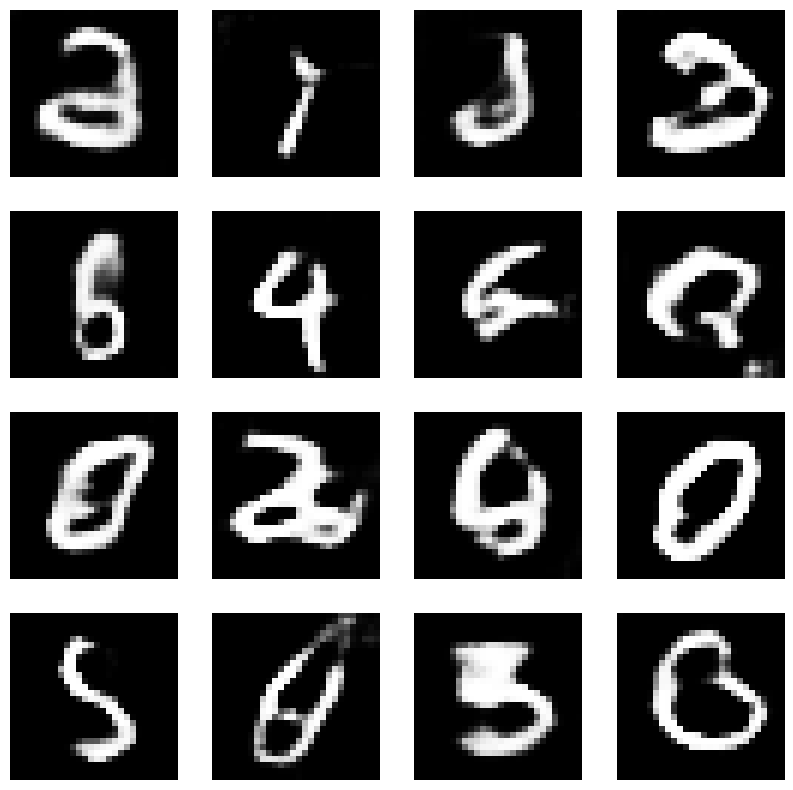

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2575 - g_loss: 0.8316
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.2636 - g_loss: 0.8184
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2782 - g_loss: 0.8864
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2745 - g_loss: 0.8129
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2828 - g_loss: 0.8316
Epoch 21/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.2979 - g_loss: 0.8777

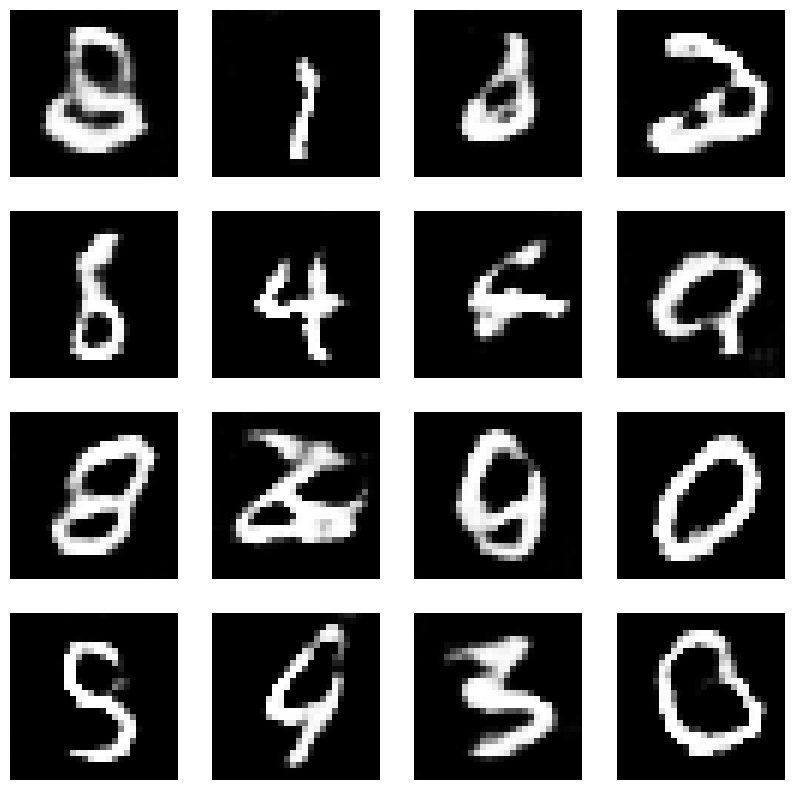

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.2965 - g_loss: 0.8810
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.2812 - g_loss: 0.8352
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.2870 - g_loss: 0.8057
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2919 - g_loss: 0.8175
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2940 - g_loss: 0.8088
Epoch 26/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 1.2956 - g_loss: 0.8147

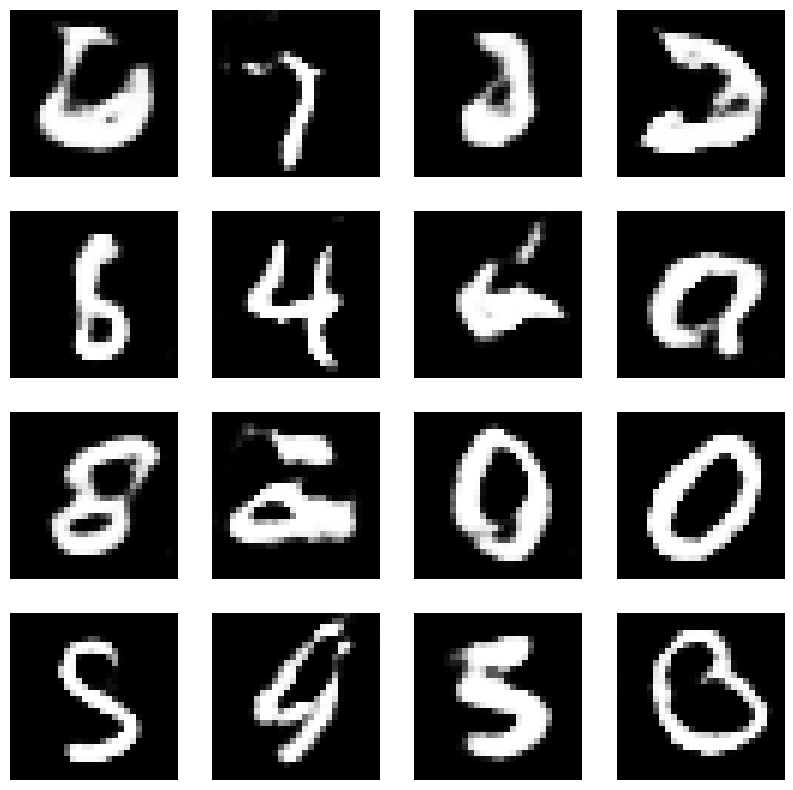

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.2954 - g_loss: 0.8147
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3045 - g_loss: 0.9114
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.2925 - g_loss: 0.7970
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2936 - g_loss: 0.7958
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.2960 - g_loss: 0.8033
Epoch 31/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.2974 - g_loss: 0.8070

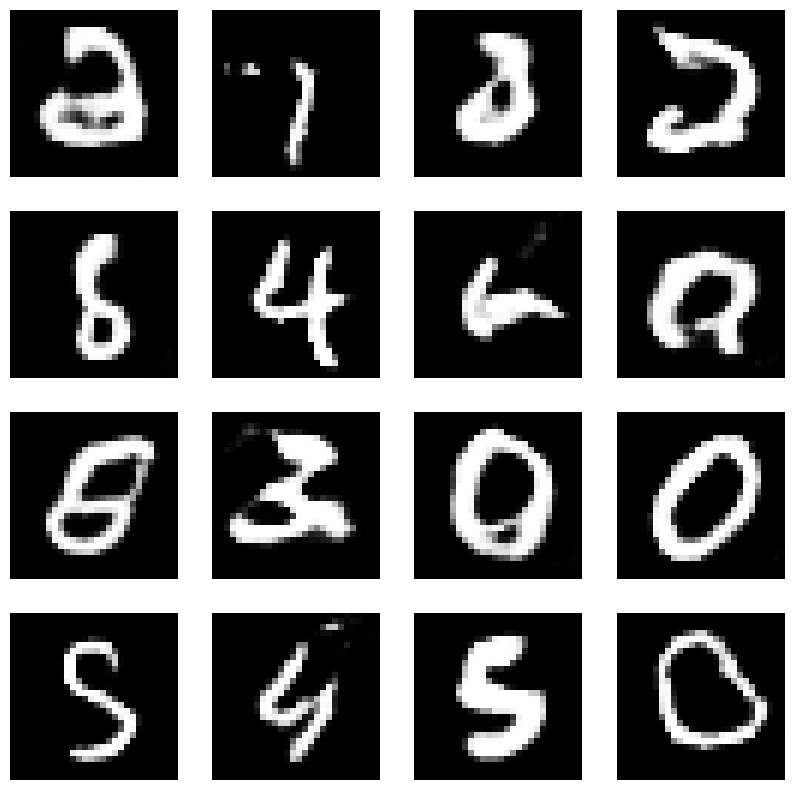

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2973 - g_loss: 0.8075
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2978 - g_loss: 0.8048
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.2995 - g_loss: 0.8023
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3058 - g_loss: 0.8235
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3024 - g_loss: 0.8054
Epoch 36/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3026 - g_loss: 0.8081

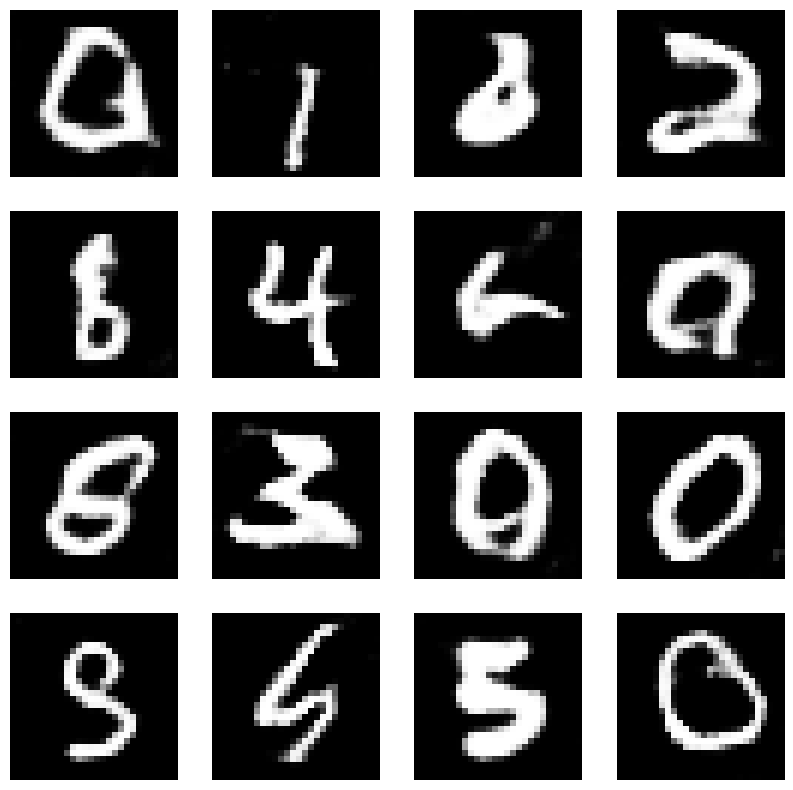

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3023 - g_loss: 0.8094
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3008 - g_loss: 0.8062
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3007 - g_loss: 0.8038
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3041 - g_loss: 0.8181
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3049 - g_loss: 0.8128
Epoch 41/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3030 - g_loss: 0.8009

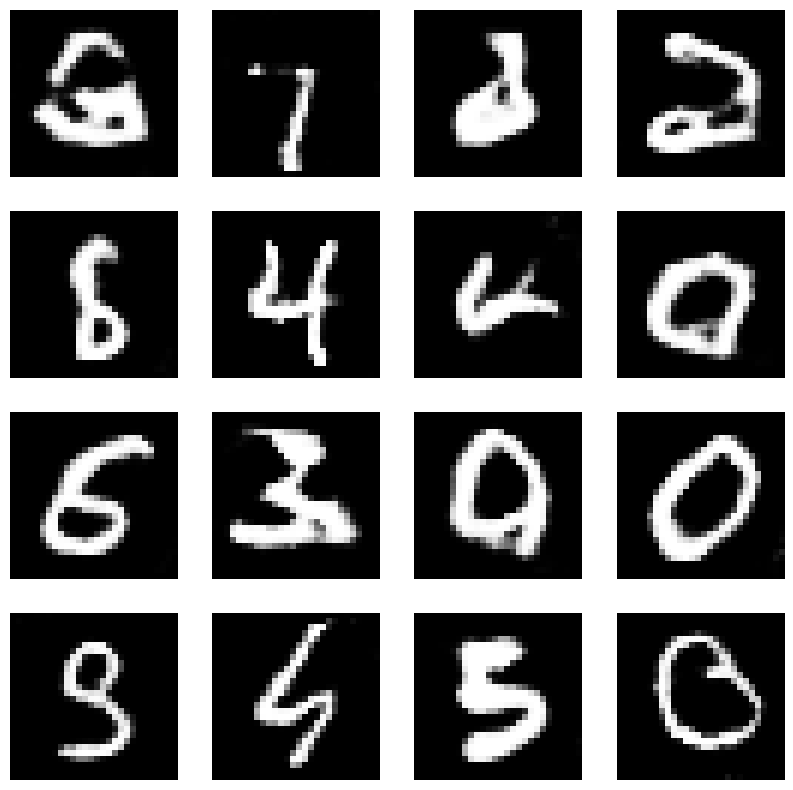

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3031 - g_loss: 0.8007
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3031 - g_loss: 0.8038
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3046 - g_loss: 0.8090
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3044 - g_loss: 0.8026
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3046 - g_loss: 0.8006
Epoch 46/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3044 - g_loss: 0.8038

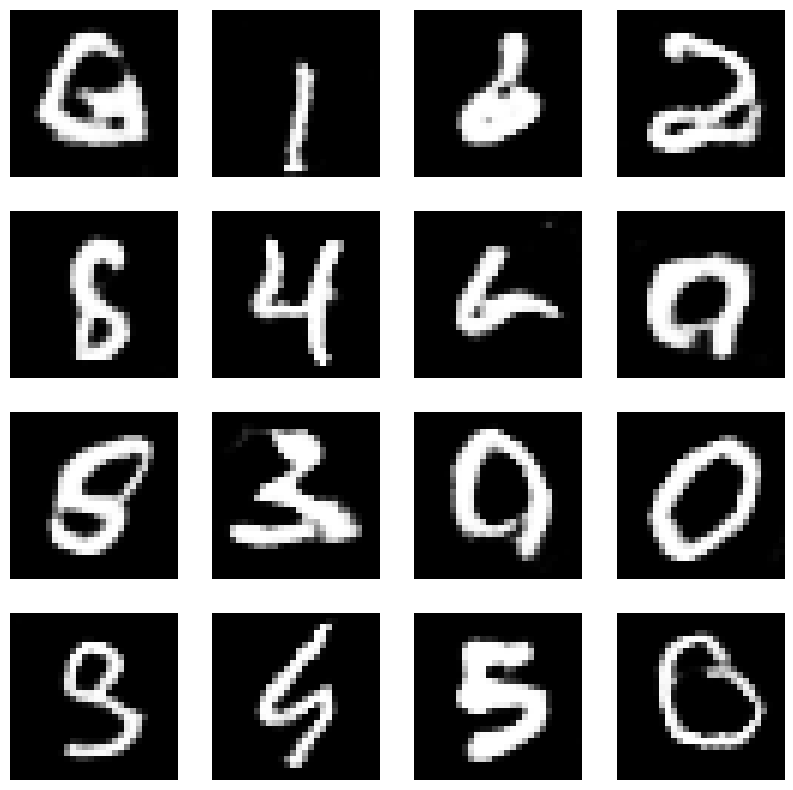

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3043 - g_loss: 0.8022
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3088 - g_loss: 0.8130
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3084 - g_loss: 0.8090
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3043 - g_loss: 0.8003
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3049 - g_loss: 0.7967
Epoch 51/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3080 - g_loss: 0.8102

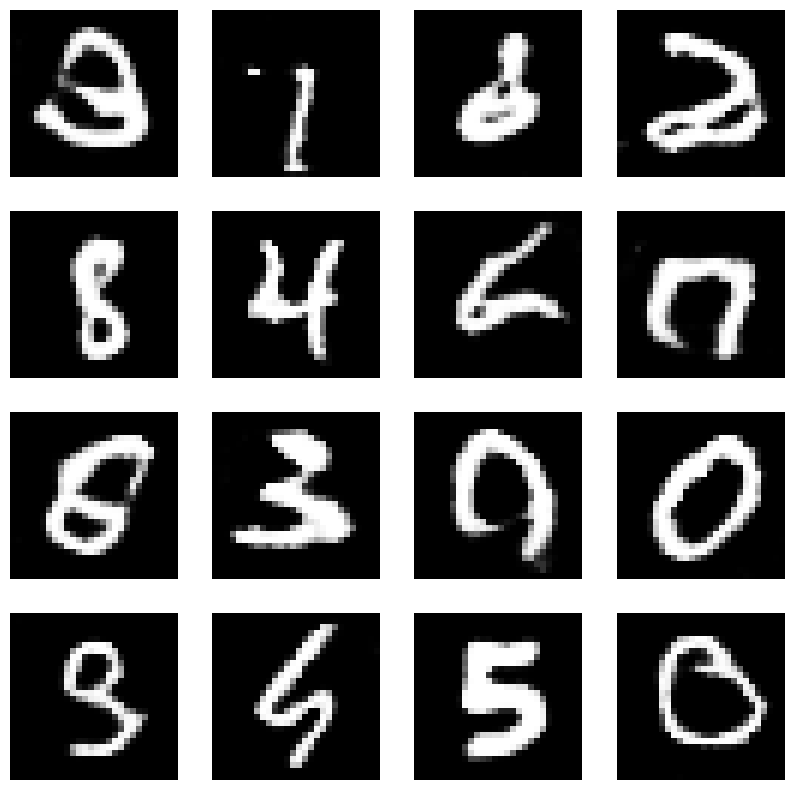

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3079 - g_loss: 0.8113
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3072 - g_loss: 0.8067
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3050 - g_loss: 0.8028
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3070 - g_loss: 0.8047
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3074 - g_loss: 0.7997
Epoch 56/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3047 - g_loss: 0.7964

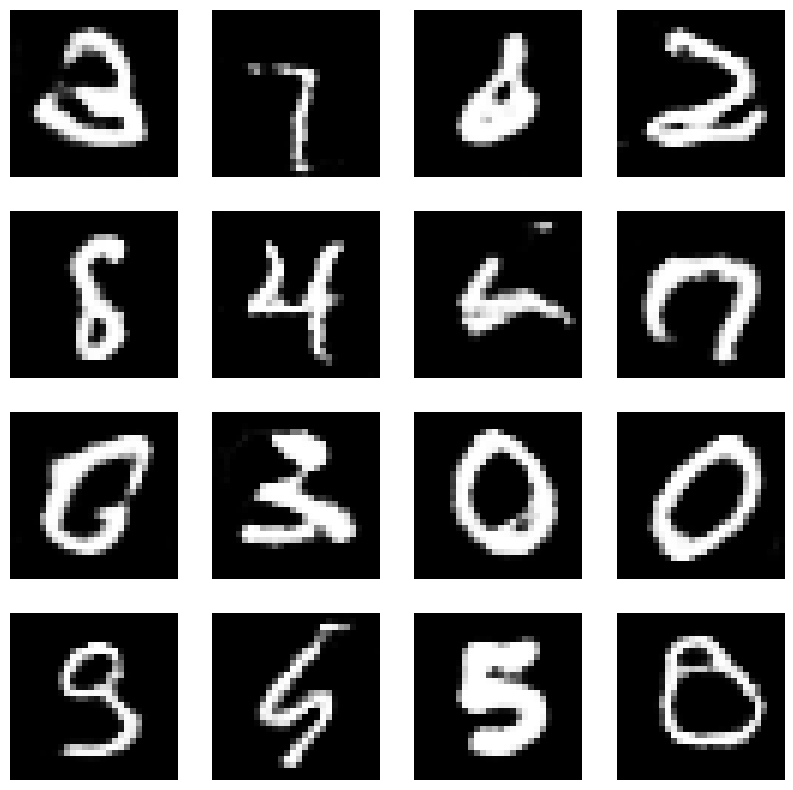

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3048 - g_loss: 0.7967
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3051 - g_loss: 0.7997
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3088 - g_loss: 0.8076
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3071 - g_loss: 0.8063
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3057 - g_loss: 0.7980
Epoch 61/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3073 - g_loss: 0.8031

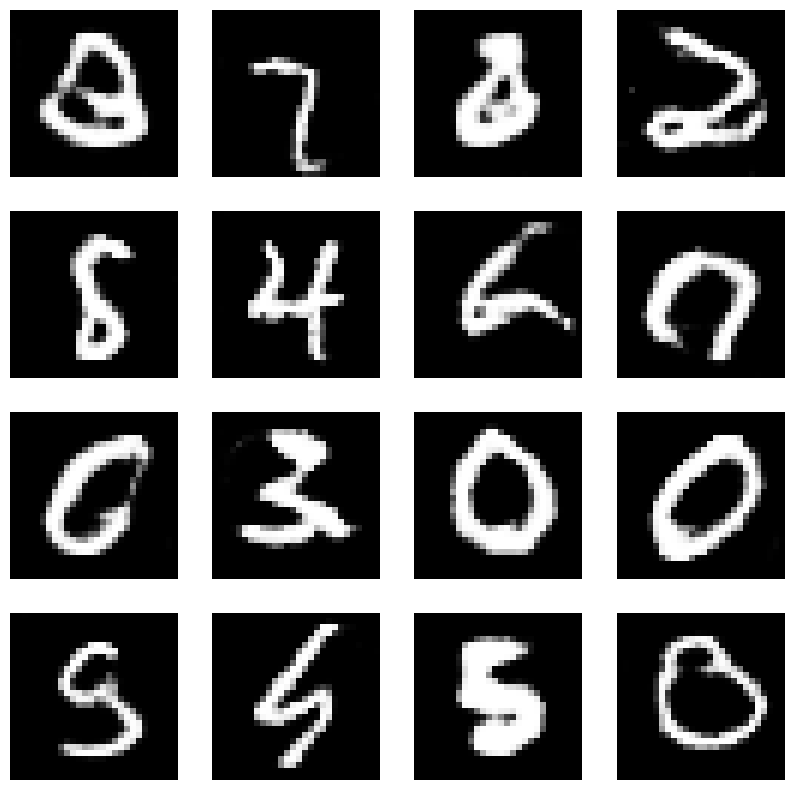

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3074 - g_loss: 0.8035
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3074 - g_loss: 0.8002
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3071 - g_loss: 0.8022
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3057 - g_loss: 0.8015
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3063 - g_loss: 0.8011
Epoch 66/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3076 - g_loss: 0.8047

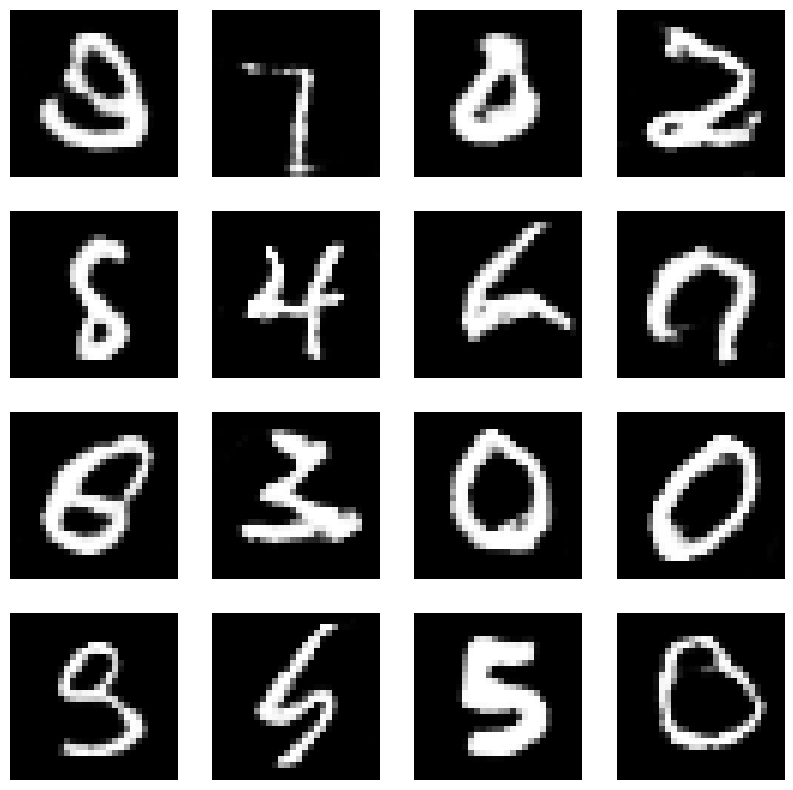

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3076 - g_loss: 0.8045
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3063 - g_loss: 0.8058
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3097 - g_loss: 0.8061
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3084 - g_loss: 0.8090
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3076 - g_loss: 0.7998
Epoch 71/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3081 - g_loss: 0.8079

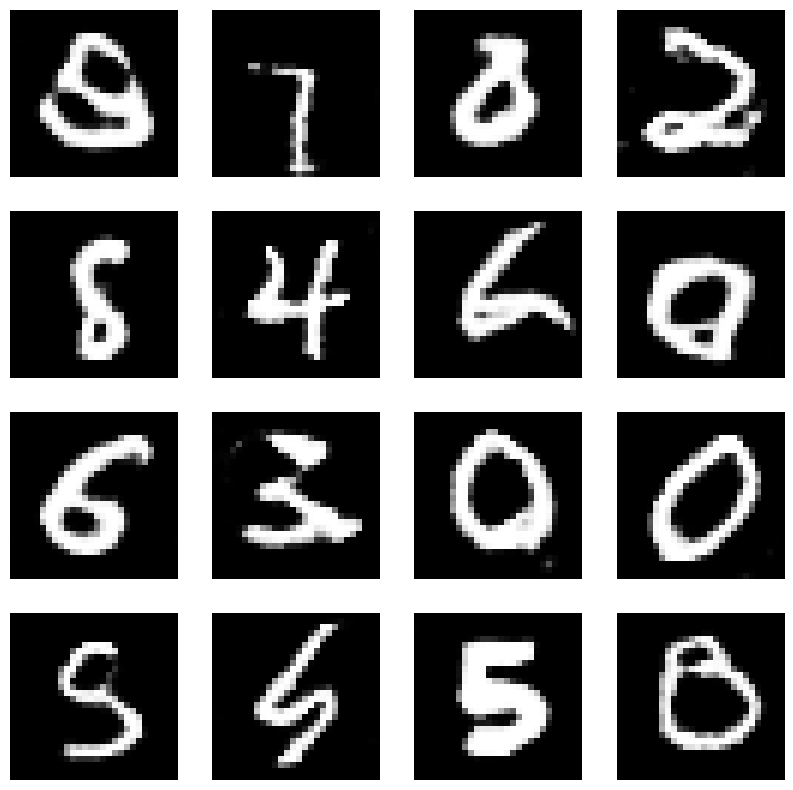

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3075 - g_loss: 0.8076
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3083 - g_loss: 0.8038
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3060 - g_loss: 0.8076
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3065 - g_loss: 0.8020
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3072 - g_loss: 0.8048
Epoch 76/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3094 - g_loss: 0.8117

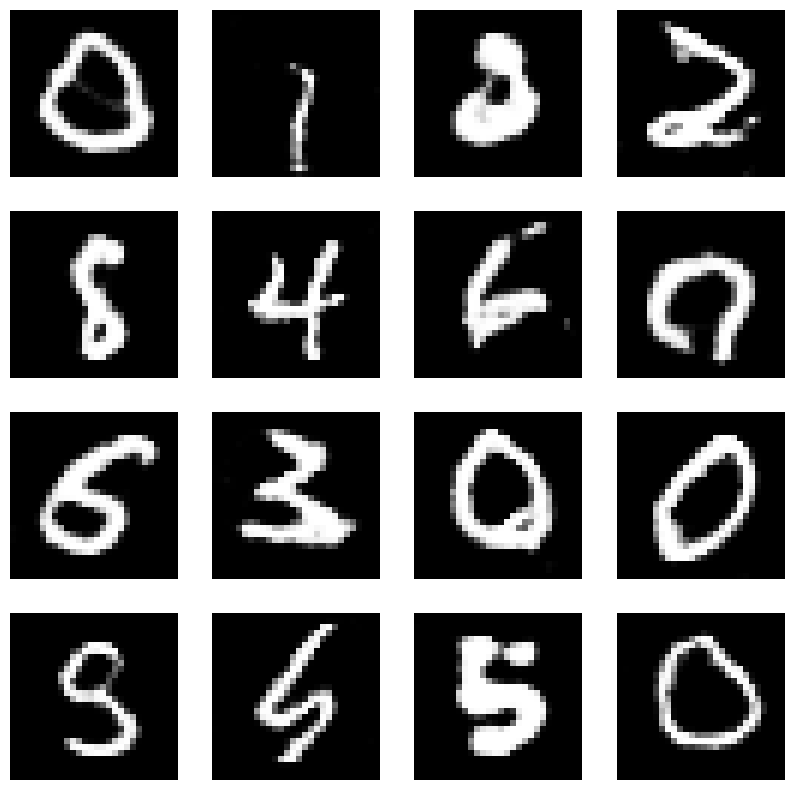

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3090 - g_loss: 0.8111
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3060 - g_loss: 0.7958
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3058 - g_loss: 0.8030
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3066 - g_loss: 0.8079
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3079 - g_loss: 0.8020
Epoch 81/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3050 - g_loss: 0.7997

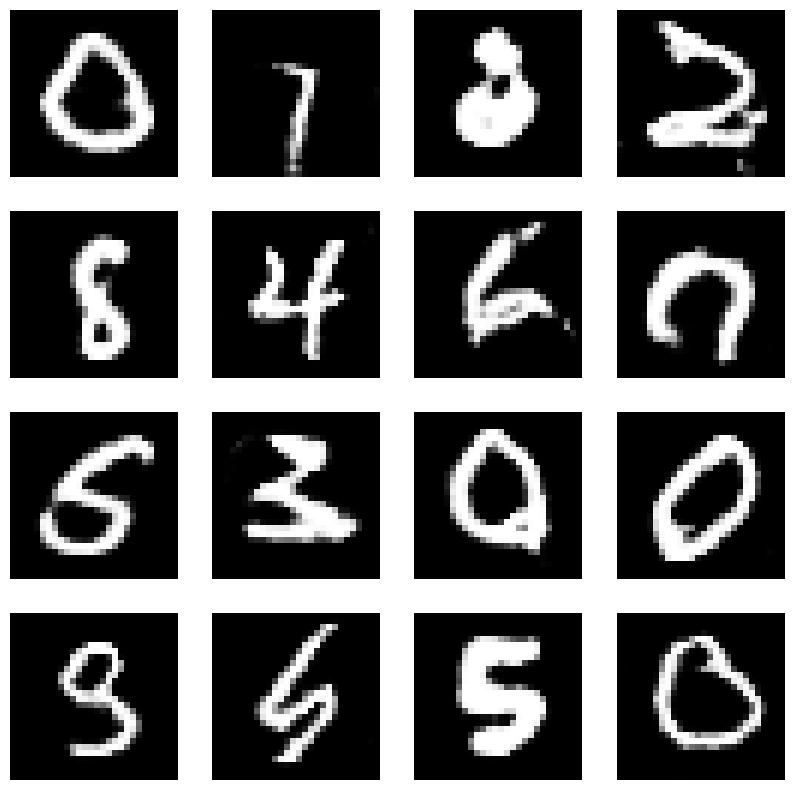

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3048 - g_loss: 0.7998
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3101 - g_loss: 0.8061
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - d_loss: 1.3046 - g_loss: 0.8043
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3035 - g_loss: 0.7997
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3068 - g_loss: 0.8020
Epoch 86/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3057 - g_loss: 0.8038

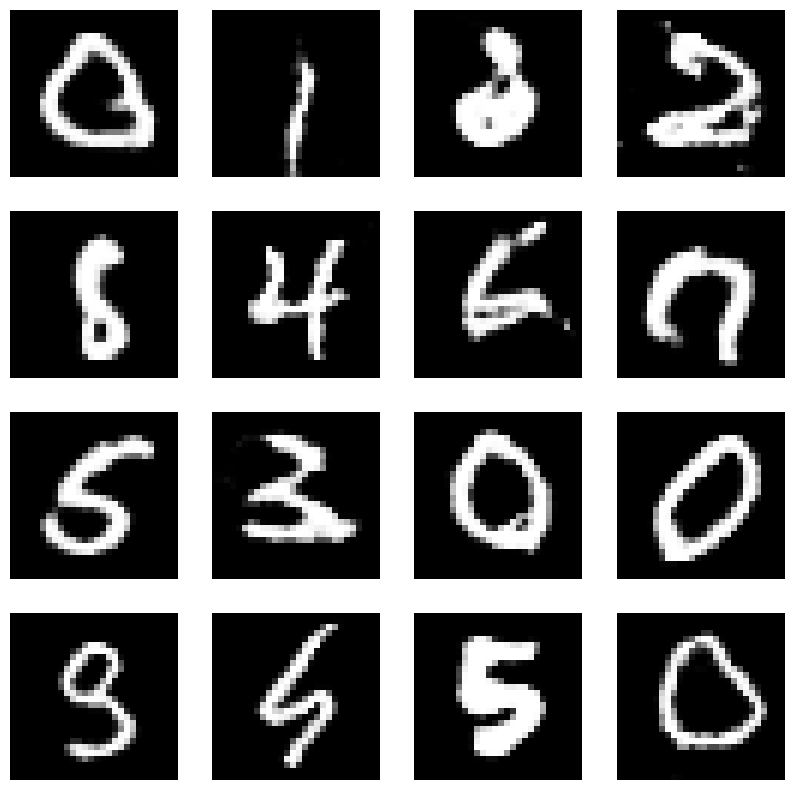

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3054 - g_loss: 0.8041
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3043 - g_loss: 0.8014
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3046 - g_loss: 0.8037
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3031 - g_loss: 0.8018
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3086 - g_loss: 0.8083
Epoch 91/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3042 - g_loss: 0.8032

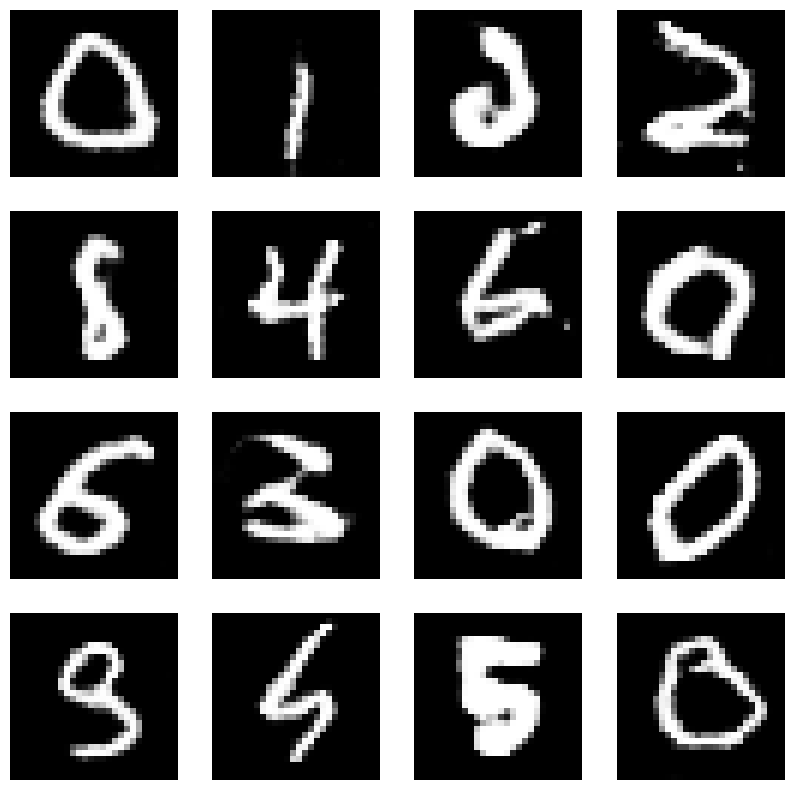

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3046 - g_loss: 0.8053
Epoch 92/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3058 - g_loss: 0.8065
Epoch 93/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3082 - g_loss: 0.8086
Epoch 94/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3049 - g_loss: 0.8066
Epoch 95/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3036 - g_loss: 0.8080
Epoch 96/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3064 - g_loss: 0.8077

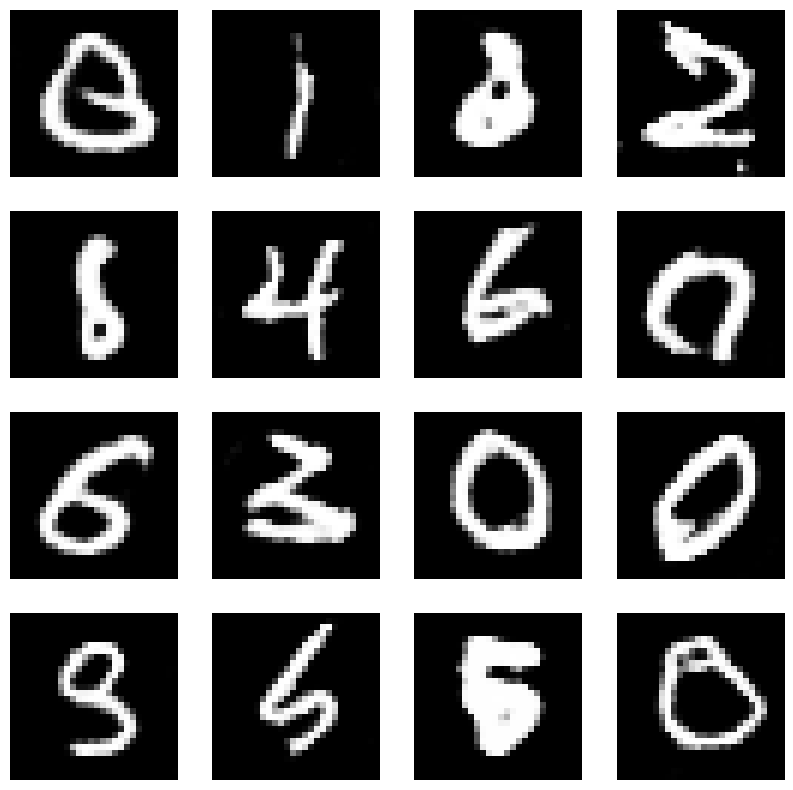

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3062 - g_loss: 0.8073
Epoch 97/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3017 - g_loss: 0.8030
Epoch 98/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3057 - g_loss: 0.8062
Epoch 99/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3064 - g_loss: 0.8084
Epoch 100/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.2998 - g_loss: 0.8024


In [46]:
history = gan.fit(train_data, epochs=Epoch, callbacks=[ImageCallback()])

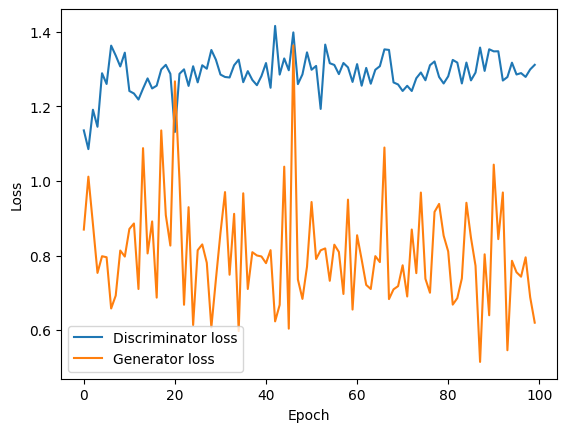

In [47]:

plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

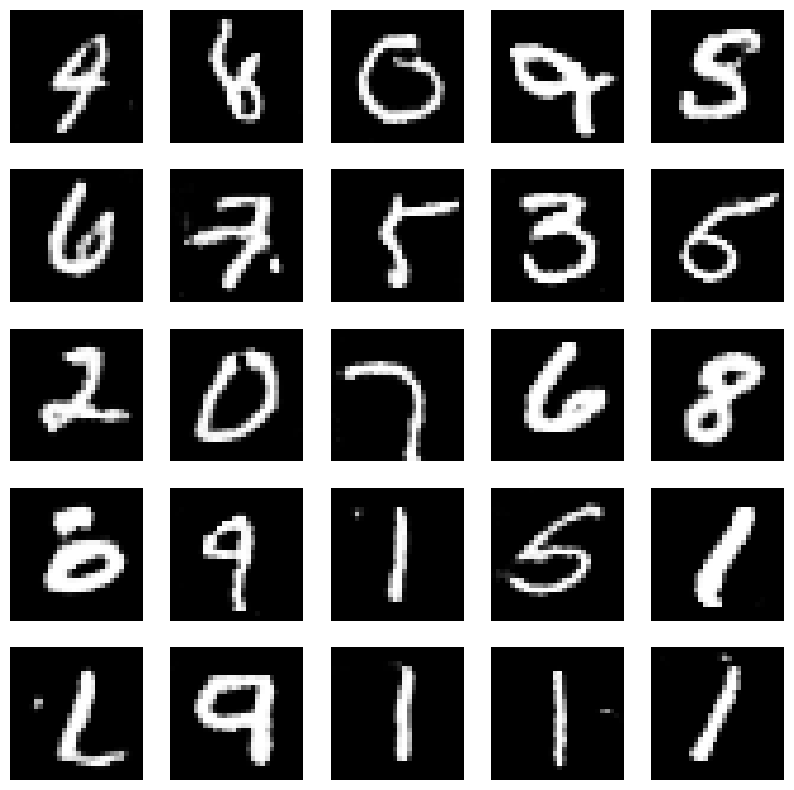

In [49]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")

plt.savefig("generated_image.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

In [50]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#generator.save("/content/drive/My Drive/mnist_gan_generator.h5")

In [ ]:
generator.save("/content/drive/My Drive/mnist_gan_generator.keras")